# 0.1.0: Explore and preprocess GBIF citizen science data


## Imports and config


In [1]:
import json
from pathlib import Path
from pprint import pprint

import dask.dataframe as dd
import h3
import numpy as np
import pandas as pd
import geopandas as gpd
import dask_geopandas as dgpd
from src.utils.dask_utils import close_dask, init_dask

from src.conf.conf import get_config
from src.conf.environment import log

%load_ext autoreload
%autoreload 2

# Display all columns when printing a pandas DataFrame
pd.set_option("display.max_columns", None)

cfg = get_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define some key paths


In [2]:
gbif_raw_dir = Path(cfg.raw_dir) / cfg.gbif.raw.dir
gbif_prep_dir = Path(cfg.interim_dir) / cfg.gbif.interim.dir
scratch_dir = Path("scratch")
scratch_dir.mkdir(parents=True, exist_ok=True)

## Explore the raw data structure


First let's just browse the directory contents.


In [3]:
print("Directory contents of the raw GBIF data:")
for file in gbif_raw_dir.iterdir():
    print(file)

Directory contents of the raw GBIF data:
data/raw/all_tracheophyta_non-cult_2024-04-10/all_tracheophyta_non-cult_2024-04-10.json
data/raw/all_tracheophyta_non-cult_2024-04-10/all_tracheophyta_non-cult_2024-04-10.parquet


Let's parse the JSON file.


In [4]:
# parse the json file
json_fn = "all_tracheophyta_non-cult_2024-04-10.json"
with open(gbif_raw_dir / json_fn) as f:
    data = json.load(f)

pprint(data)

{'created': '2024-04-10T16:03:38.992+00:00',
 'doi': '10.15468/dl.b9ptxy',
 'downloadLink': 'https://api.gbif.org/v1/occurrence/download/request/0136703-240321170329656.zip',
 'eraseAfter': '2024-10-10T16:03:38.940+00:00',
 'key': '0136703-240321170329656',
 'license': 'http://creativecommons.org/licenses/by-nc/4.0/legalcode',
 'modified': '2024-04-10T17:02:55.607+00:00',
 'numberDatasets': 12645,
 'request': {'format': 'SIMPLE_PARQUET',
             'predicate': {'predicates': [{'key': 'TAXON_KEY',
                                           'matchCase': False,
                                           'type': 'equals',
                                           'value': '7707728'},
                                          {'predicate': {'key': 'DEGREE_OF_ESTABLISHMENT',
                                                         'matchCase': False,
                                                         'type': 'in',
                                                         'values': [

We can see from the included JSON file all the metadata surrounding the data request, including the exact query, as well as other information like request date, number of datasets, and number of records.


In [5]:
print(f"Number of datasets: {data['numberDatasets']:,}")
print(f"Total records: {data['totalRecords']:,}")

Number of datasets: 12,645
Total records: 386,455,349


### Load the dataframe with Dask


Before trying to load the parquet file directly into memory, let's print the size of the data in GB (it is provided in bytes).


In [ ]:
print(f"Size of the data: {data['size'] / 1e9:.2f} GB")

Size of the data: 24.33 GB


Depending on your system, that may be a bit too big to load all at once. Especially because the data is saved in parquet format, which supports compression, so the real size may be significantly larger than that. Luckily, we can use `dask` to load large dataframes due to its ability to only load into memory exactly what we need for our given computations.


In [3]:
from src.utils.dask_utils import init_dask, close_dask

client, cluster = init_dask(dashboard_address=cfg.dask_dashboard)

In [4]:
ddf = dd.read_parquet(gbif_raw_dir / "all_tracheophyta_non-cult_2024-04-10.parquet/*")
ddf.head()

,gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,infraspecificepithet,taxonrank,scientificname,verbatimscientificname,verbatimscientificnameauthorship,countrycode,locality,stateprovince,occurrencestatus,individualcount,publishingorgkey,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,coordinateprecision,elevation,elevationaccuracy,depth,depthaccuracy,eventdate,day,month,year,taxonkey,specieskey,basisofrecord,institutioncode,collectioncode,catalognumber,recordnumber,identifiedby,dateidentified,license,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
0,4155839127,8a863029-f435-446a-821e-275f4f641165,https://observation.org/observation/243417806,Plantae,Tracheophyta,Magnoliopsida,Asterales,Asteraceae,Silybum,Silybum marianum,<NA>,SPECIES,Silybum marianum (L.) Gaertn.,Silybum marianum,<NA>,NL,Cadier en Keer,Limburg,PRESENT,1.0,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,50.80,5.75,5000.0,NaN,NaN,NaN,NaN,NaN,2022-05-29,29.0,5.0,2022.0,3145214,3145214.0,HUMAN_OBSERVATION,<NA>,Observations,OBS.243417806,<NA>,[],NaT,CC_BY_NC_4_0,Stichting Observation International,[User 418761],[],<NA>,2024-01-25 12:03:49.367,[],[OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_CO...
1,3823408376,8a863029-f435-446a-821e-275f4f641165,https://observation.org/observation/243524281,Plantae,Tracheophyta,Liliopsida,Asparagales,Iridaceae,Iris,Iris pseudacorus,<NA>,SPECIES,Iris pseudacorus L.,Iris pseudacorus,<NA>,NL,Rotterdam - Prinsenpark,Zuid-Holland,PRESENT,1.0,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,51.90,4.50,5000.0,NaN,NaN,NaN,NaN,NaN,2022-05-30,30.0,5.0,2022.0,5298231,5298231.0,HUMAN_OBSERVATION,<NA>,Observations,OBS.243524281,<NA>,[],NaT,CC_BY_NC_4_0,Stichting Observation International,[User 746719],[],<NA>,2024-01-25 12:03:26.829,[StillImage],[OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_CO...
2,4056148605,8a863029-f435-446a-821e-275f4f641165,https://observation.org/observation/243600288,Plantae,Tracheophyta,Magnoliopsida,Fabales,Fabaceae,Vicia,<NA>,<NA>,GENUS,Vicia L.,Vicia spec.,<NA>,NL,Amstelveen - Keizer Karelpark,Noord-Holland,PRESENT,1.0,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,52.25,4.85,5000.0,NaN,NaN,NaN,NaN,NaN,2022-05-31,31.0,5.0,2022.0,2974751,NaN,HUMAN_OBSERVATION,<NA>,Observations,OBS.243600288,<NA>,[],NaT,CC_BY_NC_4_0,Stichting Observation International,[User 753446],[],<NA>,2024-01-25 11:57:47.679,[StillImage],[OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_CO...
3,3904214750,8a863029-f435-446a-821e-275f4f641165,https://observation.org/observation/243760126,Plantae,Tracheophyta,Liliopsida,Asparagales,Orchidaceae,Neottia,Neottia ovata,<NA>,SPECIES,Neottia ovata (L.) Bluff & Fingerh.,Neottia ovata,<NA>,NL,Bunnik - Oud Amelisweerd,Utrecht,PRESENT,1.0,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,52.05,5.15,5000.0,NaN,NaN,NaN,NaN,NaN,2022-06-01,1.0,6.0,2022.0,2816250,2816250.0,HUMAN_OBSERVATION,<NA>,Observations,OBS.243760126,<NA>,[],NaT,CC_BY_NC_4_0,Stichting Observation International,[User 153271],[],<NA>,2024-01-25 12:04:37.647,[StillImage],[OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_CO...
4,3905757702,8a863029-f435-446a-821e-275f4f641165,https://observation.org/observation/243801621,Plantae,Tracheophyta,Magnoliopsida,Dipsacales,Caprifoliaceae,Lonicera,Lonicera periclymenum,<NA>,SPECIES,Lonicera periclymenum L.,Lonicera periclymenum,<NA>,NL,Haskerhornerpolder,Friesland,PRESENT,1.0,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,52.90,5.80,5000.0,NaN,NaN,NaN,NaN,NaN,2022-06-01,1.0,6.0,2022.0,5334277,5334277.0,HUMAN_OBSERVATION,<NA>,Observations,OBS.243801621,<NA>,[],NaT,CC_BY_NC_4_0,Stichting Observation International,[User 93322],[],<NA>,2024-01-25 11:57:59.972,[],[OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_CO...


## Analyze the raw GBIF data

- global distribution
- Num. with images
- coordinate uncertainty
- dataset information
- issues
- collection date


### Species


In [6]:
print(
    f"Total number of species (includes present and absent): {ddf['species'].nunique().compute():,}"
)

2025-01-16 11:36:46,071 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6ca058a2ca1f23828291dddd9a5fcdc4 initialized by task ('shuffle-transfer-6ca058a2ca1f23828291dddd9a5fcdc4', 16) executed on worker tcp://127.0.0.1:44523
2025-01-16 11:37:10,060 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6ca058a2ca1f23828291dddd9a5fcdc4 deactivated due to stimulus 'task-finished-1737023830.0593822'
2025-01-16 11:37:38,309 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a3595845c2e7f4e290620434ef34e3e7 initialized by task ('shuffle-transfer-a3595845c2e7f4e290620434ef34e3e7', 113) executed on worker tcp://127.0.0.1:40473
2025-01-16 11:38:56,012 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a3595845c2e7f4e290620434ef34e3e7 deactivated due to stimulus 'task-finished-1737023936.0119567'
2025-01-16 11:43:22,056 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5b912c769a5582919c106536bee950b1 initialized by task ('shuffle-transfer-5b912c769a5

Total number of species (includes present and absent): 319,214


Total number of observations


In [7]:
print(
    f"Total number of records (includes presence and absence): {ddf.shape[0].compute():,}"
)

Total number of records (includes presence and absence): 386,455,349


Top 10 most observed species globally:


In [12]:
sp_counts = ddf["species"].value_counts().compute()
sp_counts.sort_values(ascending=False).head(10).apply(lambda x: f"{x:,}")

species
Urtica dioica           1,563,131
Quercus rotundifolia    1,453,921
Plantago lanceolata     1,356,615
Dactylis glomerata      1,321,242
Trifolium repens        1,235,514
Achillea millefolium    1,211,324
Ranunculus repens       1,197,097
Holcus lanatus          1,185,530
Quercus robur           1,185,019
Fraxinus excelsior      1,148,958
Name: count, dtype: object

### Country


In [13]:
country_counts = ddf["countrycode"].value_counts().compute()
print(f"Total number of countries: {country_counts.size:,}")
country_counts.sort_values(ascending=False).head(10).apply(lambda x: f"{x:,}")

Total number of countries: 249


countrycode
FR    90,391,482
GB    31,662,658
DE    30,704,074
NL    25,438,964
US    25,025,998
AU    22,810,868
SE    19,129,422
ES    18,158,260
DK    13,590,164
CH    11,507,256
Name: count, dtype: object

Obviously this appears to be more countries than currently exist ([according to worldpopulationreview.com](https://worldpopulationreview.com/country-rankings/how-many-countries-are-there)), so there are likely some typos or non-country entities represented in the country codes.


### Dataset


In [14]:
ds_counts = ddf["datasetkey"].value_counts().compute()
print(f"Total number of datasets: {len(ds_counts):,}")
ds_counts.sort_values(ascending=False).head(10).apply(lambda x: f"{x:,}")

Total number of datasets: 12,645


datasetkey
50c9509d-22c7-4a22-a47d-8c48425ef4a7    31,140,719
75956ee6-1a2b-4fa3-b3e8-ccda64ce6c2d    20,959,498
38b4c89f-584c-41bb-bd8f-cd1def33e92f    17,305,062
8a863029-f435-446a-821e-275f4f641165    12,287,017
14d5676a-2c54-4f94-9023-1e8dcd822aa0    12,142,287
67fabcac-a638-40a6-9bea-aeca8aced9f1    12,122,651
83fdfd3d-3a25-4705-9fbe-3db1d1892b13    10,893,962
740df67d-5663-41a2-9d12-33ec33876c47    10,438,298
36555a0c-8361-42c4-9f78-805816266f2e     9,836,672
e6fab7b3-c733-40b9-8df3-2a03e49532c1     9,025,588
Name: count, dtype: object

For most of us, it's not immediately clear which datasets are represented by the keys, so we can use the datasets table provided by GBIF at https://www.gbif.org/dataset/search?type=OCCURRENCE to link the keys to readable names.


In [15]:
gbif_datasets = pd.read_csv(Path(cfg.raw_dir) / "gbif_datasets.tsv", sep="\t")
gbif_datasets.head(2)

,dataset_key,title,doi,license,type,sub_type,hosting_organization_key,hosting_organization_title,hosting_country,publishing_organization_key,publishing_organization_title,publishing_country,endorsing_node_key,network_keys,project_identifier,occurrence_records_count,name_usages_count
0,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,EOD – eBird Observation Dataset,10.15468/aomfnb,CC_BY_4_0,OCCURRENCE,NaN,e2e717bf-551a-4917-bdc9-4fa0f342c530,Cornell Lab of Ornithology,US,e2e717bf-551a-4917-bdc9-4fa0f342c530,Cornell Lab of Ornithology,US,8618c64a-93e0-4300-b546-7249e5148ed2,NaN,NaN,1512208412,0
1,38b4c89f-584c-41bb-bd8f-cd1def33e92f,Artportalen,10.15468/kllkyl,CC0_1_0,OCCURRENCE,OBSERVATION,4c415e40-1e21-11de-9e40-a0d6ecebb8bf,GBIF-Sweden,SE,b8323864-602a-4a7d-9127-bb903054e97d,SLU Artdatabanken,SE,a0b3be64-6525-4387-ac67-a499950f92e1,NaN,NaN,108577969,0


In [23]:
total_count = ds_counts.sum()
datasets = (
    gbif_datasets[["dataset_key", "title"]]
    .merge(ds_counts, left_on="dataset_key", right_index=True)[["title", "count"]]
    .assign(pct=lambda x: x["count"] / total_count)
    .set_index("title")
    .sort_values(by="count", ascending=False)
    .assign(count=lambda x: x["count"].apply(lambda y: f"{y:,}"))
    .assign(pct=lambda x: x["pct"].apply(lambda y: f"{y:.2%}"))
    .head(10)
)

datasets

,count,pct
title,,
iNaturalist Research-grade Observations,"31,140,719",8.06%
INPN - Données flore des CBN agrégées par la FCBN,"20,959,498",5.42%
Artportalen,"17,305,062",4.48%
"Observation.org, Nature data from around the World","12,287,017",3.18%
Pl@ntNet automatically identified occurrences,"12,142,287",3.14%
"Danish government nature monitoring portal ""Danmarks MiljÃ¸portals Naturdatabase","12,122,651",3.14%
Swiss National Databank of Vascular Plants,"10,893,962",2.82%
"BSBI data from several English counties, up to 2018","9,836,672",2.55%
Flora von Deutschland (Phanerogamen),"9,025,588",2.34%


### Geographic distribution


In [29]:
x = ddf.reset_index().decimallongitude.compute()
y = ddf.reset_index().decimallatitude.compute()

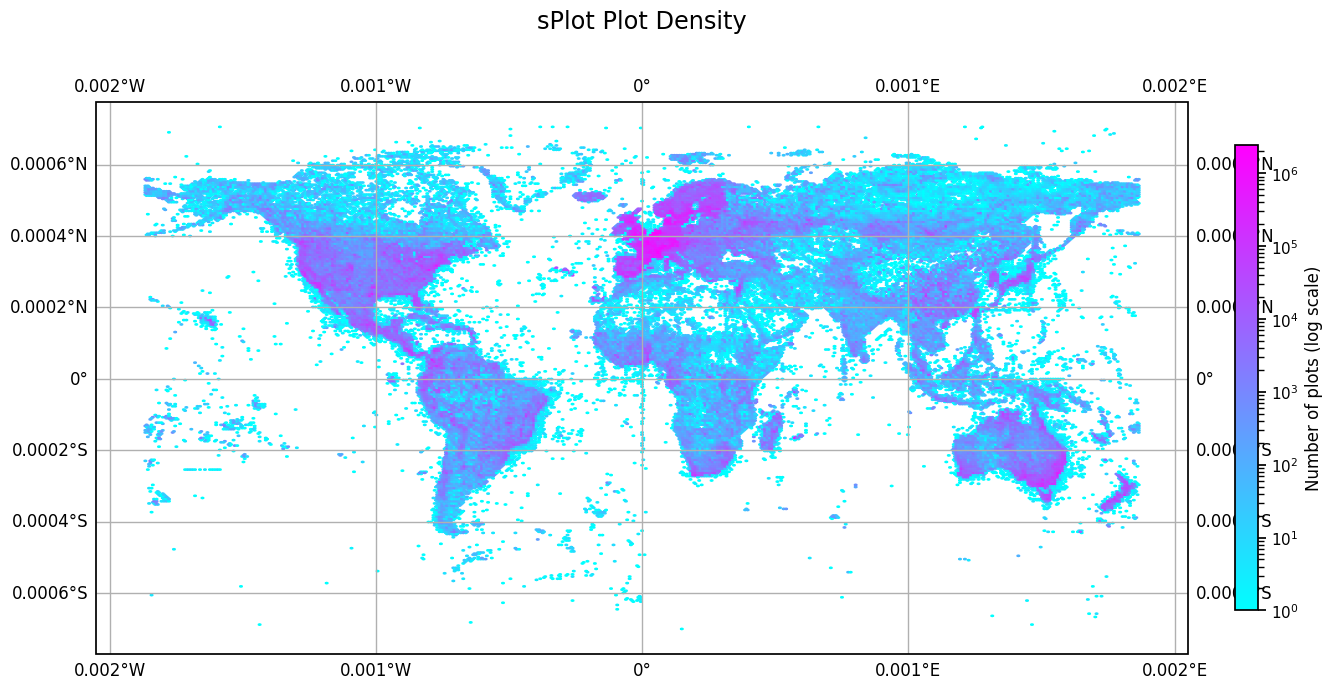

In [30]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots(
        1, 1, figsize=(15, 10), subplot_kw={"projection": ccrs.EqualEarth()}
    )

    # Plot the hexbinned density map with log scale
    hb = ax.hexbin(
        x,
        y,
        gridsize=400,
        bins="log",
        cmap="cool",
        mincnt=1,
        transform=ccrs.CRS("EPSG:6933"),
    )

    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Adjust the colorbar to be no taller than the map
    cbar = plt.colorbar(hb, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label("Number of plots (log scale)")

    plt.title("sPlot Plot Density", fontsize="x-large", pad=35)
    plt.show()

### Occurrence status


The data gives us occurence status (whether or not the species is present or absent in the observation). This could potentially be pretty valuable, as absence data information can be just as useful as presence information.


In [8]:
ddf.occurrencestatus.value_counts().compute()

occurrencestatus
ABSENT       3389108
PRESENT    383066241
Name: count, dtype: int64[pyarrow]

## Select relevant data


While there is a ton of interesting information in the GBIF data, we're primarily interested in present species, their official names, their locations, and their corresponding PFTs. Let's reload the data with only that information to reduce the memory footprint before we merge with our PFT information in TRY.


In [15]:
columns = [
    "species",
    "taxonrank",
    "decimallatitude",
    "decimallongitude",
    "occurrencestatus",
]
ddf = (
    dd.read_parquet(
        gbif_raw_dir / "all_tracheophyta_non-cult_2024-04-10.parquet/*",
        columns=columns,
    )
    .query("occurrencestatus == 'PRESENT' and taxonrank == 'SPECIES'")
    .drop(columns=["taxonrank", "occurrencestatus"])
)

## Load TRY PFTs


In [16]:
pfts = (
    dd.read_parquet(Path(cfg.raw_dir, cfg.trydb.raw.pfts))
    .drop(columns=["AccSpeciesID"])
    .repartition(npartitions=20)
)

In [8]:
pfts.head()

,AccSpeciesName,pft
0,Calamagrostis lapponica,Grass
1,Carex capitata,Grass
2,Carex rostrata,Grass
3,Carex saxatilis,Grass
4,Carex vaginata,Grass


Before matching, make sure we're dealing only with common, 2-word species names.


In [11]:
print("Species name word lengths:")
pfts.AccSpeciesName.str.split().str.len().value_counts().compute()

Species name word lengths:


2024-11-07 12:41:40,398 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f5633286dc71bba98536a8cf803429d1 initialized by task ('shuffle-transfer-f5633286dc71bba98536a8cf803429d1', 0) executed on worker tcp://127.0.0.1:41281
2024-11-07 12:41:40,496 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f5633286dc71bba98536a8cf803429d1 deactivated due to stimulus 'task-finished-1730983300.4952557'
2024-11-07 12:45:55,880 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 105397ce6494f6f735c45d02107aaf0b initialized by task ('shuffle-transfer-105397ce6494f6f735c45d02107aaf0b', 62) executed on worker tcp://127.0.0.1:35109
Task exception was never retrieved
future: <Task finished name='Task-255778' coro=<Client._gather.<locals>.wait() done, defined at /home/dl1070/miniforge3/envs/traits-py311/lib/python3.11/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/home/dl1070/miniforge3/envs/traits-py311/lib/python3.1

AccSpeciesName
1       3548
2     109849
3        719
4       6157
5         64
6         54
7         21
8         10
9          3
10         2
14         1
Name: count, dtype: int64

PFTs and GBIF species columns (not shown here due to extensive computation time) both have a many records with species names longer than two words. We can truncate each record to only the first two words in hopes that this makes matching simpler.


In [17]:
ddf["speciesname"] = (
    ddf["species"].str.extract("([A-Za-z]+ [A-Za-z]+)", expand=False).str.lower()
)
pfts["speciesname"] = (
    pfts["AccSpeciesName"]
    .str.extract("([A-Za-z]+ [A-Za-z]+)", expand=False)
    .str.lower()
)

To improve merge efficiency, we'll drop missing values and set speciesname as the index. Note that we also drop duplicate species-PFT records as standardizing the species names may have resulted in duplicate species entries.

In [18]:
ddf = (
    ddf.dropna(subset="speciesname").drop(columns=["species"]).set_index("speciesname")
)
pfts = (
    pfts.dropna(subset="speciesname")
    .drop_duplicates(subset=["speciesname", "pft"])
    .drop(columns=["AccSpeciesName"])
    .set_index("speciesname")
)

Calculate number of species and observations in both GBIF and TRY.


In [19]:
num_species_gbif = ddf.index.nunique().compute()
num_obs_gbif = ddf.shape[0].compute()

num_species_try = pfts.index.nunique().compute()
num_obs_try = pfts.shape[0].compute()

In [23]:
print("GBIF:")
print(f"Number of observed species: {num_species_gbif:,}")
print(f"Number of observations: {num_obs_gbif:,}\n\n")

print("TRY:")
print(f"Number of observed species: {num_species_try:,}")

GBIF:
Number of observed species: 314,217
Number of observations: 339,971,350


TRY:
Number of observed species: 111,070


Now we can merge the PFT information into the GBIF data and then reset the index.


In [21]:
gbif_linked = ddf.join(pfts, how="inner").reset_index()

And save the results directly to disk to speed up future operations on the merged DataFrame.


In [23]:
gbif_linked.to_parquet(scratch_dir / "gbif_linked.parquet", write_index=False)

## Inspect matched GBIF / PFT data


In [4]:
client, cluster = init_dask(dashboard_address=cfg.dask_dashboard, n_workers=1)

In [8]:
close_dask(client, cluster)

In [5]:
gbif_linked = dd.read_parquet(scratch_dir / "gbif_linked.parquet").compute()
# gbif_linked.head(npartitions=3)
gbif_linked.head()

,speciesname,decimallatitude,decimallongitude,pft
0,aa argyrolepis,-0.66600,-78.50000,Grass
1,aa argyrolepis,-2.60000,-78.66600,Grass
2,aa argyrolepis,-0.18389,-78.72889,Grass
3,aa argyrolepis,-0.18389,-78.72889,Grass
4,aa calceata,-14.82278,-68.19111,Shrub


In [16]:
gbif_linked.speciesname.value_counts().compute().sort_values(ascending=False)

speciesname
dactylis glomerata            8126321
urtica dioica                 7291475
achillea millefolium          6726528
pteridium aquilinum           3508794
trifolium repens              3476229
                               ...   
stigmaphyllon ecuadorense           1
tridax purpurea                     1
verbesina pseudoclaussenii          1
vernonia undulata                   1
xyris itambensis                    1
Name: count, Length: 88540, dtype: int64[pyarrow]

### Total number of observations after matching GBIF with TRY


In [25]:
print(f"Total number of observations: {gbif_linked.shape[0].compute():,}")

Total number of observations: 305,452,677


Interesting. After merging GBIF with TRY PFT records, we have an increase in the total number of observations. Let's explore why.

Given the varying methods of collection among all of the constituent datasets that make up GBIF, many observations may appear identical---that is, sharing the same species, latitude, and longitude. At the moment, we cannot know which observations are true duplicates and which are not.

To demonstrate, we can look at the number of "duplicate" observations in GBIF.


In [38]:
deduped_size_gbif = ddf.reset_index().drop_duplicates().shape[0].compute()

In [39]:
print(f'{deduped_size_gbif:,} spatially "unique" observations in GBIF')
print(f'Percentage of "unique" observations: {deduped_size_gbif / num_obs_gbif:.2%}')

200,181,361 spatially "unique" observations in GBIF
Percentage of "unique" observations: 58.88%


As we can see, almost 40% of the observations in GBIF share the same species name and location as another observation.

That said, the likely reason why we have "more" observations after matching GBIF with TRY PFTs is due to species in TRY being members of more than one PFT. Let's see.


In [40]:
deduped_size_pfts = pfts.reset_index()[["speciesname"]].compute().duplicated().sum()
print(f"{deduped_size_pfts:,} duplicates in TRY PFT list")

6,157 duplicates in TRY PFT list


This means that for each species in TRY that is able to be matched GBIF, if that species has multiple PFTs assigned to it, then each GBIF observation will be duplicated as well. Not only will this potentially bias multi-PFT maps toward multi-PFT species, it also confounds the calculation of intersection between GBIF and TRY.

The former issue would require more sophistication to solve, perhaps through the implementation of biome-based matching. The latter issue can be addressed more straight-forwardly.

All we need to do is deduplicate the TRY list before matching with GBIF to get a true count of observations matched.


In [10]:
# Get only GBIF records where species name is in unique_try_species
matched_records = ddf.join(
    pfts.reset_index().drop_duplicates(subset=["speciesname"]).set_index("speciesname"),
    how="inner",
).reset_index()

In [11]:
num_matched_species = matched_records["speciesname"].nunique().compute()
num_matched_records = matched_records.shape[0].compute()
print(f"Number of matched species: {num_matched_species:,}")
print(f"Number of matched records: {num_matched_records:,}")

2025-01-16 15:32:33,522 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c8acc1524b2bed9870ab853d2cb02578 initialized by task ('shuffle-transfer-c8acc1524b2bed9870ab853d2cb02578', 7) executed on worker tcp://127.0.0.1:45601
2025-01-16 15:32:33,870 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bae4c7e0ddb9ee3111bb82170837dbf6 initialized by task ('shuffle-transfer-bae4c7e0ddb9ee3111bb82170837dbf6', 7) executed on worker tcp://127.0.0.1:41575
2025-01-16 15:32:34,257 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c8acc1524b2bed9870ab853d2cb02578 deactivated due to stimulus 'task-finished-1737037954.246855'
2025-01-16 15:32:34,480 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bae4c7e0ddb9ee3111bb82170837dbf6 deactivated due to stimulus 'task-finished-1737037954.4689999'
2025-01-16 15:32:35,069 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c8acc1524b2bed9870ab853d2cb02578 initialized by task ('shuffle-transfer-c8acc1524b2bed9

Number of matched species: 88,802
Number of matched records: 303,288,097


These numbers are more reasonable. Let's look at percentages compared to the original GBIF and TRY figures.


In [24]:
print(
    f"{num_matched_species / num_species_gbif:.2%} of GBIF species are in TRY (n={num_matched_species:,})"
)
print(
    f"{num_matched_records / num_obs_gbif:.2%} of GBIF observations were maintained (n={num_matched_records:,})"
)

print(f"{num_matched_species / num_species_try:.2%} of TRY species are in GBIF")

28.26% of GBIF species are in TRY (n=88,802)
89.21% of GBIF observations were maintained (n=303,288,097)
79.95% of TRY species are in GBIF


Plot the number of observations for each PFT.


In [ ]:
# Plot the number of observations for each PFT
import matplotlib.pyplot as plt

pft_counts = gbif_linked.pft.value_counts().compute().sort_values(ascending=False)

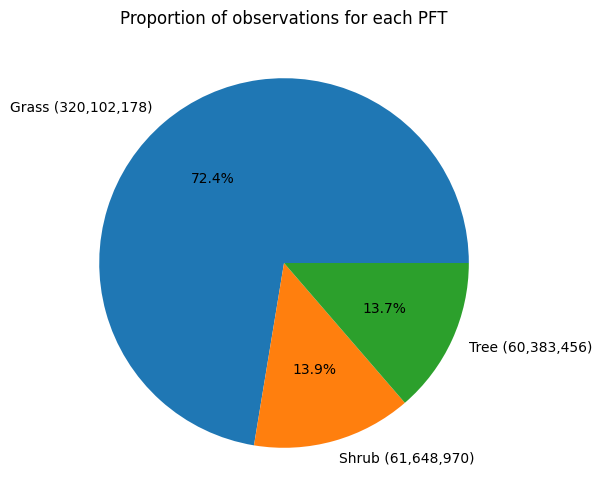

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot pft counts with legend (include the actual counts as well as the percentages)
ax.pie(
    pft_counts,
    labels=[
        f"{label} ({count:,})" for label, count in zip(pft_counts.index, pft_counts)
    ],
    autopct="%1.1f%%",
)
ax.set_title("Proportion of observations for each PFT")
plt.show()

In [20]:
unique_species_gbif_linked = gbif_linked.speciesname.nunique().compute()
unique_species_gbif = ddf.index.nunique().compute()
unique_species_try = pfts.index.nunique().compute()

print(
    f"Species matched from GBIF: {unique_species_gbif_linked / unique_species_gbif:.2%}"
)
print(
    f"Species matched from PFTS: {unique_species_gbif_linked / unique_species_try:.2%}"
)

Species matched from GBIF: 28.18%
Species matched from PFTS: 80.03%


In [21]:
print(f"Total number of species: {unique_species_gbif_linked:,}")

Total number of species: 88,540


## Subsample GBIF data with a regular hexagonal grid


One issue with the GBIF data is that species occurrences are obtained opportunistically and [tend to be clustered toward the global north](https://www.gbif.org/occurrence/map?occurrence_status=present). To reduce this sampling bias such that our GBIF data is more spatially balanced, we can subsampled the data by first binning it into equally spaced hexagons and then selecting a maximum number of observations from each hexagon.


In [4]:
def lat_lon_to_hex(lat: float, lon: float, resolution: int | float = 0.5):
    return h3.geo_to_h3(lat, lon, resolution)


def apply_hex_to_partition(df):
    if len(df) > 0:
        return df.assign(
            hex=lat_lon_to_hex_vectorized(
                df.decimallatitude, df.decimallongitude, resolution=10
            )
        )
    else:
        return df


def sample_partition(df, n_samples=10000):
    return df.groupby(level=0).apply(
        lambda group: group if len(group) <= n_samples else group.sample(n_samples)
    )


# subsample the data first for testing
gbif_pfts = gbif_pfts.sample(frac=0.001)

# Vectorize the function
lat_lon_to_hex_vectorized = np.vectorize(lat_lon_to_hex)

meta = gbif_pfts._meta.assign(hex=pd.Series(dtype="object"))

# Apply the function to each partition
gbif_pfts = gbif_pfts.map_partitions(apply_hex_to_partition, meta=meta)

gbif_pfts = gbif_pfts.set_index("hex", npartitions=180)

meta = gbif_pfts._meta_nonempty.sample(0)

subsampled_gbif_pfts = gbif_pfts.map_partitions(
    sample_partition, n_samples=1000, meta=meta
).compute()

# subsampled_gbif_pfts.to_parquet(
#     gbif_prep_dir / cfg.gbif.interim.subsampled, write_index=False
# )

As we can see, with a grid size of 4 degrees and a sample size of 1,000 occurrences per grid cell, we've reduced the number of occurrences to ~19%. If everything went well, we should have the same number of hex cells in the original gbif_pfts dataframe as in the subsampled dataframe. We should also see a maximum of 1,000 occurrences in the hex bins.


In [15]:
subsampled_gbif_pfts.reset_index(drop=True).shape[0] / gbif_pfts.shape[0].compute()

0.18786533327592

In [19]:
gbif_pfts.reset_index().hex.nunique().compute()

59641

In [30]:
subsampled_gbif_pfts.reset_index(level=0).reset_index(drop=True).hex.nunique()

59641

In [39]:
print(
    "Average number of occurrences per hex bin: "
    f"{subsampled_gbif_pfts.reset_index(level=0).groupby(level=0).size().mean():.2f}"
)

print(
    "Maximum number of occurrences per hex bin: "
    f"{subsampled_gbif_pfts.reset_index(level=0).groupby(level=0).size().max():,}"
)

Average number of occurrences per hex bin: 139.94
Maximum number of occurrences per hex bin: 1,000


## Read the subsampled data and plot the density


In [35]:
from src.utils.dask_utils import close_dask


gbif = dd.read_parquet(gbif_prep_dir / cfg.gbif.interim.subsampled).compute()
close_dask(client, cluster)

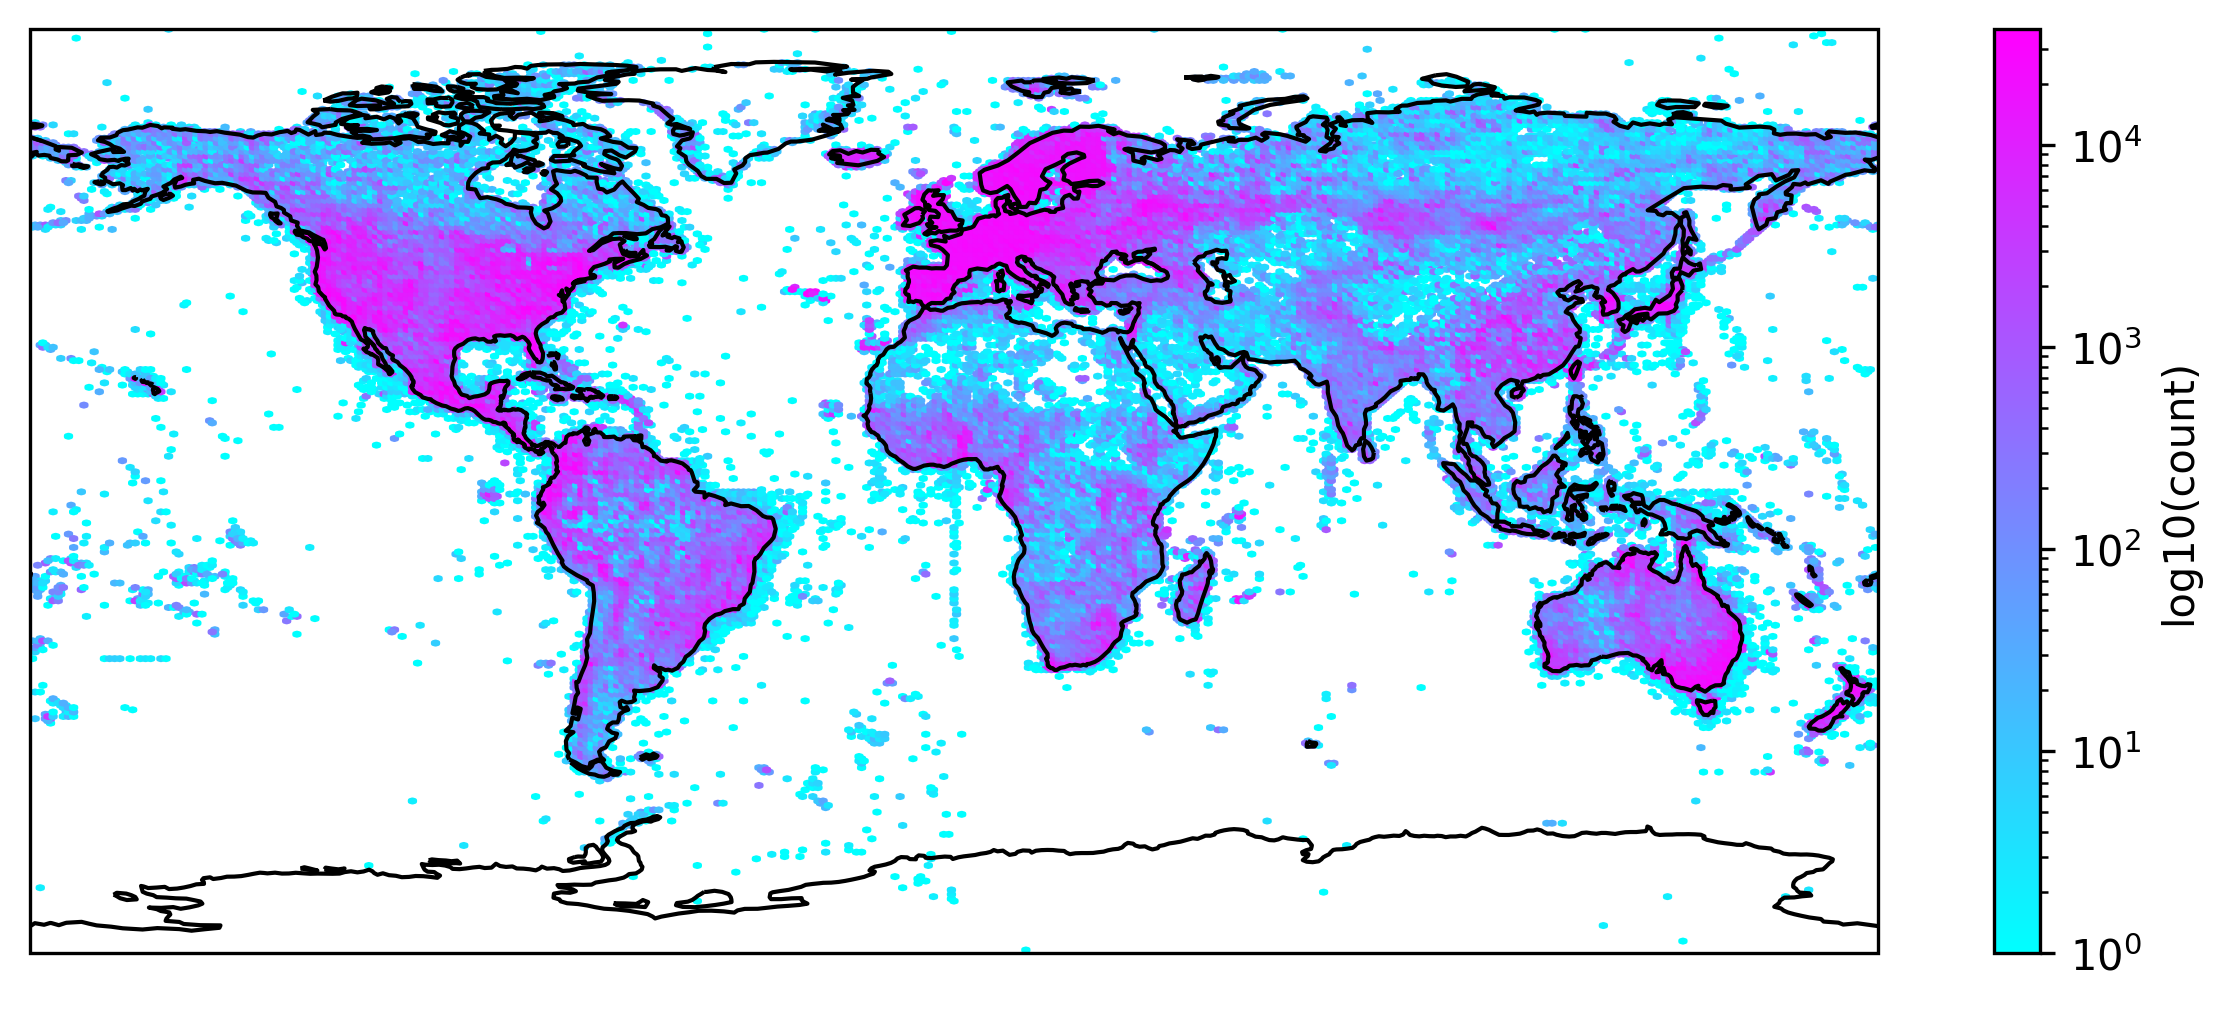

In [ ]:
# Plot the gbif_sample density using matplotlib hexbin
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import transform

fig, ax = plt.subplots(
    figsize=(10, 4), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300
)
hb = ax.hexbin(
    gbif.decimallongitude,
    gbif.decimallatitude,
    transform=ccrs.PlateCarree(),
    gridsize=360,
    cmap="cool",
    bins="log",
)
ax.coastlines()
plt.colorbar(hb, label="log10(count)")